### Downloading the Price datasets

#### Prices from Investing.com
BTC: https://www.investing.com/crypto/bitcoin/historical-data <br>
ETH: https://www.investing.com/crypto/ethereum/historical-data <br>
SOL: https://www.investing.com/crypto/solana/historical-data <br>
SNP500: https://www.investing.com/indices/us-spx-500-historical-data <br>
VIX: https://www.investing.com/indices/volatility-s-p-500-historical-data <br>
GOLD: https://www.investing.com/commodities/gold-historical-data

#### TVL from DeFi Lama
BTC: https://defillama.com/chain/Bitcoin <br>
ETH: https://defillama.com/chain/Ethereum <br>
SOL: https://defillama.com/chain/Solana

#### Wikipedia Page Views
ALL: https://pageviews.wmcloud.org/

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
# 1. Removing the Comma from the price action 
def comma_form(column): 
    column = column.str.replace(',', '')
    column = pd.to_numeric(column, errors='coerce')
    return column

# 2. Converting the Volume Function 
def convert_volume(volume):
    # Check if the value is a string and needs conversion
    if isinstance(volume, str):
        factor = 1
        if volume.endswith('K'):
            factor = 10**3
        elif volume.endswith('M'):
            factor = 10**6
        elif volume.endswith('B'):
            factor = 10**9
        # Remove the last character and convert to float
        return float(volume[:-1]) * factor
    else:
        # If not a string, return as is (assuming it's already a numeric type)
        return volume
    
# 3. Adjusting the Change % Column 
def percent(percent):
    return pd.to_numeric(percent.str.replace('%', '')) / 100

# 4. Date Selection
def date_filter(df, start_date_str, end_date_str):
    # Convert start and end date strings to datetime
    start_date = pd.to_datetime(start_date_str, dayfirst=True)
    end_date = pd.to_datetime(end_date_str, dayfirst=True)

    # Filter based on the date range
    mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
    return df.loc[mask]

# 5. Apply Filter
def apply_filter(df, apply_comma_form=True, apply_convert_volume=True, apply_percent=True, start_date_str=None, end_date_str=None):
    df.Date = pd.to_datetime(df.Date)

    if apply_convert_volume:
        if 'Vol.' in df.columns:
            df['Volume'] = df['Vol.'].apply(convert_volume)

    if apply_percent:
        if 'Change %' in df.columns:
            df['Change %'] = percent(df['Change %'])

    if apply_comma_form:
        for col in df.columns:
            if df[col].dtype == 'object':
                df[col] = comma_form(df[col])
                       
    if start_date_str and end_date_str:
        df = date_filter(df, start_date_str, end_date_str)
    df = df[['Date', 'Price', 'Change %', 'Open', 'High', 'Low', 'Volume']]    
    return df

### Prepare Pricing Data

In [54]:
btc = pd.read_csv('data/price/btc.csv')
eth = pd.read_csv('data/price/eth.csv')
sol = pd.read_csv('data/price/sol.csv')

btc = apply_filter(btc)
sol = apply_filter(sol, apply_comma_form=False)
eth = apply_filter(eth, apply_comma_form=False)

#### Adding in reddit_sentiment data

In [55]:
btc_reddit = pd.read_csv('data/model/btc_reddit_sen.csv')
btc_reddit = btc_reddit[['date_posted', 'weighted_sentiment']]
btc_reddit.date_posted = pd.to_datetime(btc_reddit.date_posted)
btc = pd.merge(btc, btc_reddit, left_on='Date', right_on='date_posted', how='left')

def fill_missing_with_avg(df, column):
    data = df[column].copy()
    n = len(data)
    
    for i in range(1, n-1):
        if pd.isnull(data[i]):
            if pd.notnull(data[i-1]) and pd.notnull(data[i+1]) and pd.isnull(data[i+1:i+2]).sum() == 0:
                data[i] = (data[i-1] + data[i+1]) / 2

    df[column] = data
    return df

btc = fill_missing_with_avg(btc, 'weighted_sentiment')

btc

,Date,Price,Change %,Open,High,Low,Volume,date_posted,weighted_sentiment
0,2024-06-11,67191.4,-0.0337,69537.9,69573.3,66766.3,81720.0,2024-06-11,-0.055700
1,2024-06-10,69538.2,-0.0016,69650.2,70152.5,69259.9,39120.0,2024-06-10,0.373901
2,2024-06-09,69650.6,0.0049,69310.5,69847.8,69136.7,20990.0,2024-06-09,0.119032
3,2024-06-08,69310.1,-0.0005,69347.0,69572.1,69222.4,23030.0,2024-06-08,-0.052684
4,2024-06-07,69347.9,-0.0204,70793.4,71956.5,68620.7,82620.0,2024-06-07,-0.070606
...,...,...,...,...,...,...,...,...,...
1619,2020-01-05,7372.5,-0.0006,7376.8,7501.0,7345.6,628140.0,NaT,NaN
1620,2020-01-04,7376.8,0.0046,7345.1,7433.1,7291.4,523910.0,NaT,NaN
1621,2020-01-03,7343.1,0.0540,6967.1,7402.9,6884.1,936290.0,NaT,NaN
1622,2020-01-02,6967.0,-0.0323,7199.7,7209.6,6901.4,632780.0,NaT,NaN


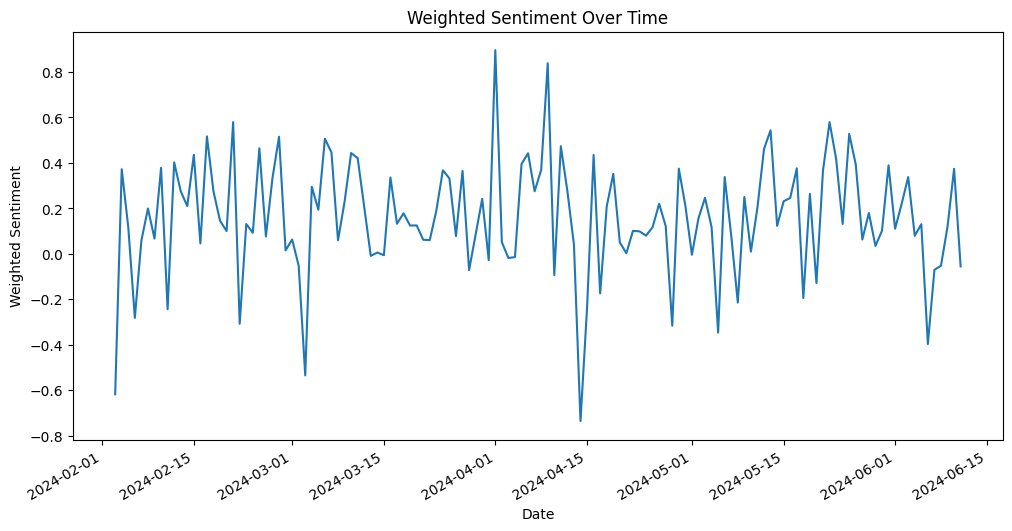

In [56]:
extt = btc.copy()
extt = extt.dropna()
# Convert 'Date' column to datetime
extt['Date'] = pd.to_datetime(extt['Date'])

# Set 'Date' as the index
extt.set_index('Date', inplace=True)

# Plot 'weighted_sentiment' with 'Date' as x-axis
plt.figure(figsize=(12, 6))  # Set the figure size to make the plot wider
extt['weighted_sentiment'].plot()
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.title('Weighted Sentiment Over Time')
plt.show()

#### Adding Wikipedia Page Views and Google Trends Data

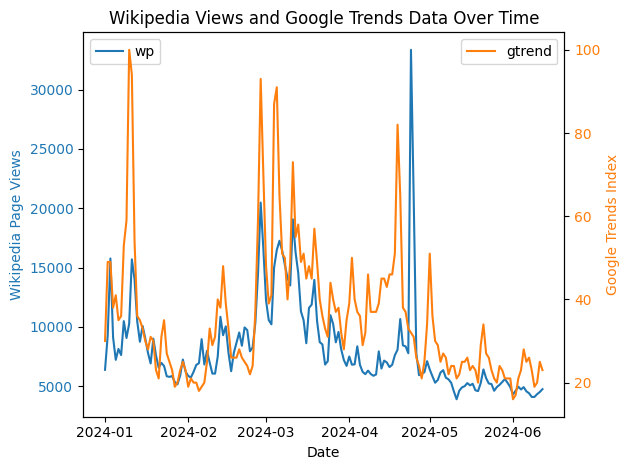

In [57]:
btc_wp = pd.read_csv('data/ext/btc_wp.csv')
btc_gtrends = pd.read_csv('data/ext/btc_gtrends.csv')
btc_gtrends = btc_gtrends[1:]
btc_gtrends['Date'] = btc_gtrends.index
btc_wp.rename(columns={'Bitcoin': 'Wikipedia_Views'}, inplace=True)
btc_gtrends.rename(columns={'Category: All categories': 'Google_Trends'}, inplace=True)
btc_gtrends.Date = pd.to_datetime(btc_gtrends.Date)
btc_wp.Date = pd.to_datetime(btc_wp.Date)

ext = pd.merge(btc_wp, btc_gtrends, on='Date', how='left')
ext['Google_Trends'] = ext['Google_Trends'].astype(float)
btc = pd.merge(btc, ext) # Merging ext data to main df



# Create the plot
fig, ax1 = plt.subplots()

# Plot 'wp' on the primary y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Wikipedia Page Views', color='tab:blue')
ax1.plot(ext['Date'], ext['Wikipedia_Views'], color='tab:blue', label='wp')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for 'gtrend'
ax2 = ax1.twinx()
ax2.set_ylabel('Google Trends Index', color='tab:orange')
ax2.plot(ext['Date'], ext['Google_Trends'], color='tab:orange', label='gtrend')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Title and layout
plt.title('Wikipedia Views and Google Trends Data Over Time')
fig.tight_layout()  # To ensure the labels do not overlap

# Show the plot
plt.show()

In [58]:
btc = pd.merge(btc, ext, on='Date', how='left')
btc.Date = pd.to_datetime(btc.Date)

#### Adding the TVL Data

In [59]:
btc_tvl = pd.read_csv('data/tvl/btc_tvl.csv')
eth_tvl = pd.read_csv('data/tvl/eth_tvl.csv')
sol_tvl = pd.read_csv('data/tvl/sol_tvl.csv')

def tvl_pro(df):
    df = df[:1]
    df = df.melt(var_name='Date', value_name='TVL')
    df = df.drop(index=0).reset_index(drop=True)
    df.Date = pd.to_datetime(df.Date, dayfirst=True)
    return df

btc_tvl, eth_tvl, sol_tvl = tvl_pro(btc_tvl), tvl_pro(eth_tvl), tvl_pro(sol_tvl)

#btc, eth, sol = pd.merge(btc, btc_tvl, on='Date', how='left'), pd.merge(eth, eth_tvl, on='Date', how='left'), pd.merge(sol, sol_tvl, on='Date', how='left')
btc = pd.merge(btc, btc_tvl, on='Date', how='left')
btc


,Date,Price,Change %,Open,High,Low,Volume,date_posted,weighted_sentiment,Wikipedia_Views_x,Google_Trends_x,Wikipedia_Views_y,Google_Trends_y,TVL
0,2024-06-11,67191.4,-0.0337,69537.9,69573.3,66766.3,81720.0,2024-06-11,-0.055700,4501,25.0,4501,25.0,1104883926.148234
1,2024-06-10,69538.2,-0.0016,69650.2,70152.5,69259.9,39120.0,2024-06-10,0.373901,4316,20.0,4316,20.0,1164491247.051705
2,2024-06-09,69650.6,0.0049,69310.5,69847.8,69136.7,20990.0,2024-06-09,0.119032,4082,19.0,4082,19.0,1158554012.969358
3,2024-06-08,69310.1,-0.0005,69347.0,69572.1,69222.4,23030.0,2024-06-08,-0.052684,4084,23.0,4084,23.0,1159399106.674628
4,2024-06-07,69347.9,-0.0204,70793.4,71956.5,68620.7,82620.0,2024-06-07,-0.070606,4392,26.0,4392,26.0,1186340539.253732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,2024-01-05,44156.9,0.0000,44163.0,44312.1,42629.0,68070.0,NaT,NaN,7212,41.0,7212,41.0,319142424.024755
159,2024-01-04,44157.0,0.0308,42836.1,44744.5,42632.8,68050.0,NaT,NaN,9113,38.0,9113,38.0,309519348.463304
160,2024-01-03,42836.1,-0.0469,44943.7,45492.7,40888.3,117650.0,NaT,NaN,15761,49.0,15761,49.0,325693087.810681
161,2024-01-02,44943.7,0.0172,44182.9,45885.4,44166.0,97840.0,NaT,NaN,9267,49.0,9267,49.0,316328729.58009


#### Proccess Gold, SNP, and VIX Data

In [60]:
gold = pd.read_csv('data/price/gold.csv')
snp = pd.read_csv('data/price/snp.csv')
vix = pd.read_csv('data/price/vix.csv')

gold.Date, snp.Date, vix.Date = pd.to_datetime(gold.Date), pd.to_datetime(snp.Date), pd.to_datetime(vix.Date)

# 2. Applying the Comma function on Prices
gold.Price, snp.Price = comma_form(gold.Price), comma_form(snp.Price)
gold.Open, snp.Open = comma_form(gold.Open), comma_form(snp.Open)
gold.High, snp.High = comma_form(gold.High), comma_form(snp.High)
gold.Low, snp.Low= comma_form(gold.Low), comma_form(snp.Low)

# 3. Renaming Volume and applying fomatting
gold['Volume'], snp['Volume']= gold['Vol.'], snp['Vol.']
gold.Volume, snp.Volume = gold.Volume.apply(convert_volume), snp.Volume.apply(convert_volume)

# 4. Applying the PCT Change Column
gold['Change %'], snp['Change %'], vix['Change %']  = percent(gold['Change %']), percent(snp['Change %']), percent(vix['Change %'])
gold['pct_change'], snp['pct_change'], vix['pct_change'] = gold['Change %'], snp['Change %'], vix['Change %']

# 5. Deleting old formatted columns
gold, snp, vix = gold.drop(['Vol.', 'Change %'], axis = 1), snp.drop(['Vol.', 'Change %'], axis = 1), vix.drop(['Vol.', 'Change %'], axis = 1)

###### A function to fill in missing dates in Gold, SNP, and VIX prices from the previous column. This is because on the weekends the markets are closed

In [61]:
# Fill missing dates and prices
def fill_missing_data(df):
    # Convert 'Date' to datetime
    df['Date'] = pd.to_datetime(df['Date'])

# Set the date as the index
    df.set_index('Date', inplace=True)

# Create a date range from the min to the max date in the DataFrame
    date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the DataFrame to the new date range
    df = df.reindex(date_range)

# Fill missing values by propagating the last valid observation forward
    df.fillna(method='ffill', inplace=True)

# Reset the index to get the date column back
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Date'}, inplace=True)
    
    return df

gold, snp, vix = fill_missing_data(gold), fill_missing_data(snp), fill_missing_data(vix)
gold

,Date,Price,Open,High,Low,Volume,pct_change
0,2020-01-02,1528.1,1521.00,1534.00,1519.7,270550.0,0.0033
1,2020-01-03,1552.4,1531.70,1556.60,1530.4,436740.0,0.0159
2,2020-01-04,1552.4,1531.70,1556.60,1530.4,436740.0,0.0159
3,2020-01-05,1552.4,1531.70,1556.60,1530.4,436740.0,0.0159
4,2020-01-06,1568.8,1562.70,1590.90,1562.3,558970.0,0.0106
...,...,...,...,...,...,...,...
1618,2024-06-07,2325.0,2395.70,2406.70,2304.2,314550.0,-0.0276
1619,2024-06-08,2325.0,2395.70,2406.70,2304.2,314550.0,-0.0276
1620,2024-06-09,2325.0,2395.70,2406.70,2304.2,314550.0,-0.0276
1621,2024-06-10,2327.0,2311.00,2331.30,2304.5,142890.0,0.0009


#### Merging Gold, SNP, and VIX Datatables

In [62]:
ext = pd.merge(gold, snp, on='Date')
ext = pd.merge(ext, vix, on='Date')

# Assuming df is your DataFrame
ext.rename(columns={
    'Price_x': 'Gold_Price',
    'Open_x': 'Gold_Open',
    'High_x': 'Gold_High',
    'Low_x': 'Gold_Low',
    'Volume_x': 'Gold_Volume',
    'pct_change_x': 'Gold_pct_change',
    'Price_y': 'SNP_Price',
    'Open_y': 'SNP_Open',
    'High_y': 'SNP_High',
    'Low_y': 'SNP_Low',
    'Volume_y': 'SNP_Volume',
    'pct_change_y': 'SNP_pct_change',
    'Price': 'VIX_Price',
    'Open': 'VIX_Open',
    'High': 'VIX_High',
    'Low': 'VIX_Low',
    'pct_change': 'VIX_pct_change'
}, inplace=True)

##### Creating the 'tomorrow' independent variable

In [63]:
def tomorrow(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date', ascending=False)
    df['Tomorrow'] = df.Price.shift(1)
    df['Tomorrow'] = (df.Tomorrow > df.Price).astype(int)
    return df

btc, eth, sol = tomorrow(btc), tomorrow(eth), tomorrow(sol)

##### Join Gold, SNP, and VIX to Crypto Price Dataset

In [64]:
def join_other(df):
    df = pd.merge(df, ext, on='Date', how='left')
    return df
btc_1, eth_1, sol_1 = join_other(btc), join_other(eth), join_other(sol)

##### Function to create the technical indicators

In [65]:
def technical_analysis(df):
    # Create a copy of the input DataFrame
    ta = df.copy()
    
    # 10D MA
    ta['MA'] = ta.Price.rolling(window=10).mean()
    ta['MA_td'] = (ta.Price > ta.MA).astype(int)
    
    # 30D MA
    ta['3MA'] = ta.Price.rolling(window=30).mean()
    ta['3MA_td'] = (ta.Price > ta['3MA']).astype(int)
    
    # %K
    lowest_low = ta.Low.rolling(window=10).min()
    highest_high = ta.High.rolling(window=10).max()
    ta['%K'] = (ta.Price - lowest_low) / (highest_high - lowest_low) * 100
    ta['%K_td'] = (ta['%K'] > ta['%K'].shift(1)).astype(int)
    
    # Calculate %D
    ta['%D'] = ta['%K'].rolling(window=3).mean()
    ta['%D_td'] = (ta['%D'] > ta['%D'].shift(1)).astype(int)
    
    # RSI 
    delta = ta.Price.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    ta['RSI'] = 100 - (100 / (1 + rs))
    
    def RSI_td(rsi_values):
        if rsi_values >= 70:
            return -1
        elif rsi_values <= 30:
            return 1
        else:
            return 0
    
    ta['RSI_td'] = ta.RSI.apply(RSI_td)
    
    # Momentum 
    momentum_window = 10 
    ta['Momentum'] = ta.Price - ta.Price.shift(momentum_window)
    ta['Momentum_td'] = (ta.Momentum > 1).astype(int)
    
    # MACD 12,26,9
    ta['EMA12'] = ta.Price.ewm(span=12, adjust=False).mean()
    ta['EMA26'] = ta.Price.ewm(span=26, adjust=False).mean()
    ta['MACD'] = ta['EMA12'] - ta['EMA26']
    ta['Signal'] = ta['MACD'].ewm(span=9, adjust=False).mean()
    ta['MACD_td'] = (ta['MACD'] > ta['MACD'].shift(1)).astype(int)
    
    # CCI
    ta['TP'] = (ta['High'] + ta['Low'] + ta['Price']) / 3
    
    # Calculate the 20-period Simple Moving Average of the Typical Price
    ta['SMA_TP'] = ta['TP'].rolling(window=20).mean()
    
    def calculate_md(series):
        return abs(series - series.mean()).mean()
    
    ta['MD'] = ta['TP'].rolling(window=20).apply(calculate_md)
    
    # Calculate the CCI
    ta['CCI'] = (ta['TP'] - ta['SMA_TP']) / (0.015 * ta['MD'])
    
    def CCI_td(CCI_values):
        if CCI_values >= 100:
            return -1
        elif CCI_values <= -100:
            return 1
        else:
            return 0
    
    ta['CCI_td'] = ta.CCI.apply(CCI_td)

    ta = ta[['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'pct_change','TVL', 'weighted_sentiment',
       'Tomorrow', 'Gold_Price', 'Gold_Open', 'Gold_High', 'Gold_Low',
       'Gold_Volume', 'Gold_pct_change', 'SNP_Price', 'SNP_Open', 'SNP_High',
       'SNP_Low', 'SNP_Volume', 'SNP_pct_change', 'VIX_Price', 'VIX_Open',
       'VIX_High', 'VIX_Low', 'VIX_pct_change','MA_td','3MA_td',
       '%K_td','%D_td','RSI_td',
       'Momentum_td','MACD_td','CCI_td','Wikipedia_Views_x','Google_Trends_x']]

    return ta

In [66]:
#btcc, ethh, soll = technical_analysis(btc_1), technical_analysis(eth_1), technical_analysis(sol_1)
btcc = technical_analysis(btc_1)

KeyError: "['pct_change'] not in index"

Sample Dataset for BTC

In [155]:
btcc.head(10)

,Date,Price,Open,High,Low,Volume,pct_change,TVL,weighted_sentiment,Tomorrow,...,MA_td,3MA_td,%K_td,%D_td,RSI_td,Momentum_td,MACD_td,CCI_td,Wikipedia_Views_x,Google_Trends_x
0,2024-06-11,67191.4,69537.9,69573.3,66766.3,81720.0,-0.0337,1104883926.148234,-0.055700,0,...,0,0,0,0,0,0,0,0,4501,25.0
1,2024-06-10,69538.2,69650.2,70152.5,69259.9,39120.0,-0.0016,1164491247.051705,0.373901,0,...,0,0,0,0,0,0,1,0,4316,20.0
2,2024-06-09,69650.6,69310.5,69847.8,69136.7,20990.0,0.0049,1158554012.969358,0.119032,0,...,0,0,0,0,0,0,1,0,4082,19.0
3,2024-06-08,69310.1,69347.0,69572.1,69222.4,23030.0,-0.0005,1159399106.674628,-0.052684,1,...,0,0,0,0,0,0,1,0,4084,23.0
4,2024-06-07,69347.9,70793.4,71956.5,68620.7,82620.0,-0.0204,1186340539.253732,-0.070606,0,...,0,0,0,0,0,0,1,0,4392,26.0
5,2024-06-06,70791.5,71083.6,71616.1,70178.7,49790.0,-0.0041,1192592052.885545,-0.397443,0,...,0,0,0,0,0,0,1,0,4558,25.0
6,2024-06-05,71083.7,70550.9,71744.4,70397.1,67060.0,0.0076,1195948698.097365,0.130097,0,...,0,0,0,0,0,0,1,0,4909,28.0
7,2024-06-04,70549.2,68808.0,71034.2,68564.3,75690.0,0.0253,1166483982.760765,0.079258,1,...,0,0,0,0,0,0,1,0,4713,23.0
8,2024-06-03,68807.8,67763.3,70131.0,67616.8,69420.0,0.0153,1145947560.522376,0.337554,1,...,0,0,0,0,0,0,0,0,4948,21.0
9,2024-06-02,67773.5,67760.8,68447.5,67330.6,30630.0,0.0002,1144634501.808956,0.219684,1,...,0,0,0,0,0,0,0,0,4610,17.0


Saving the datasets for further proccessing 

In [156]:
btcc.to_csv('data/model/btc_model_price.csv')
#ethh.to_csv('data/model/eth_model_price.csv')
#soll.to_csv('data/model/sol_model_price.csv')